In [1]:
import os
import gzip
import random
import zipfile 
import tensorflow as tf
import numpy as np
from tqdm import tqdm
from PIL import Image
from matplotlib import pyplot
from urllib.request import urlretrieve

In [2]:
%matplotlib inline

### Constants

MNIST data for GAN testing

In [3]:
# # source: http://yann.lecun.com/exdb/mnist/
MNIST_URL = "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz"
MNIST_FILE_NAME = "train-images-idx3-ubyte.gz"

MNIST_IMAGE_WIDTH = 28
MNIST_IMAGE_HEIGHT = 28
MNIST_NUM_CHANNELS = 1
MNIST_PIXEL_DEPTH = 255
MNIST_NUM_LABELS = 10

MNIST_TRAIN_IMAGES_NUM = 60000

CELEBA data with faces of celebrities

In [4]:
# http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html
# direct download link from Udacity - Deep Learning Nanodegree
CELEBA_URL = "https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip"
CELEBA_ZIP_FILE_NAME = "img_align_celeba.zip"
CELEBA_FOLDER_DIR = "./img_align_celeba"

CELEBA_IMAGE_ORIGINAL_WIDTH = 178
CELEBA_IMAGE_ORIGINAL_HEIGHT = 218
CELEBA_FACE_HEIGHT = 108

CELEBA_IMAGE_RESHAPED_WIDTH = 28
CELEBA_IMAGE_RESHAPED_HEIGHT = 28
CELEBA_NUM_CHANNELS = 3
CELEBA_PIXEL_DEPTH = 255

CELEBA_IMAGES_TOTAL_NUM = 202599
CELEBA_IMAGES_NUM = 202500

### Load data

Helper methods

In [ ]:
class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num 

In [6]:
def extract_mnist_images(file_path, num_images, image_width, image_height):
    with gzip.open(file_path) as bstream:
        bstream.read(16)
        buffer = bstream.read(image_width * image_height * num_images)
        data = np.frombuffer(buffer, dtype=np.uint8)
        data = data.reshape(num_images, image_width, image_height, 1)
        return data

In [7]:
def load_celeb_images(images_dir, images_num, face_height, image_width, image_height):
    images = list()
    for i, file_name in enumerate(os.listdir(images_dir)):
        if i < images_num:
            image = Image.open(images_dir + "/" + file_name)
            
            x = (image.size[0] - face_height) // 2
            y = (image.size[1] - face_height) // 2
            
            image_reshaped = image.crop([x, y, x + face_height, y + face_height])
            image_reshaped = image.resize([image_width, image_height], Image.BILINEAR)
            
            images.append(np.array(image_reshaped.convert("RGB")))
    return np.array(images).astype(np.uint8)

Downloading MNIST:

In [8]:
if not os.path.isfile(MNIST_FILE_NAME):
    with DLProgress(unit="B", unit_scale=True, miniters=1, desc="Mnist: " + filename) as pbar:
        urlretrieve(MNIST_URL, filename, pbar.hook)

In [9]:
mnist_images_raw = extract_mnist_images(
    "train-images-idx3-ubyte.gz", MNIST_TRAIN_IMAGES_NUM, MNIST_IMAGE_WIDTH, MNIST_IMAGE_HEIGHT)

Downloading CelebA:

In [10]:
if not os.path.isfile(CELEBA_ZIP_FILE_NAME):
    with DLProgress(unit="B", unit_scale=True, miniters=1, desc="CelebA: " + CELEBA_ZIP_FILE_NAME) as pbar:
        urlretrieve(CELEBA_URL, CELEBA_ZIP_FILE_NAME, pbar.hook)

In [11]:
if not os.path.isdir(CELEBA_FOLDER_DIR):
    with zipfile.ZipFile(CELEBA_ZIP_FILE_NAME, 'r') as zip_ref:
        zip_ref.extractall("./")

In [12]:
celeba_images_raw = load_celeb_images(CELEBA_FOLDER_DIR, CELEBA_IMAGES_NUM, CELEBA_FACE_HEIGHT, 
                                      CELEBA_IMAGE_RESHAPED_WIDTH, CELEBA_IMAGE_RESHAPED_HEIGHT)

### Preprocess data

In [13]:
def normalize(x, pixel_depth):
    x_float = x.astype(np.float32)
    return 2 * ((x_float / pixel_depth) - 0.5)

In [14]:
mnist_images_preprocessed = np.array(
    [normalize(i, MNIST_PIXEL_DEPTH) for i in mnist_images_raw])

In [15]:
print("MNIST preprocessed: ")
print("  - shape: " + str(mnist_images_preprocessed.shape))
print("  - min_value: " + str(mnist_images_preprocessed.min()))
print("  - max_value: " + str(mnist_images_preprocessed.max()))

MNIST preprocessed: 
  - shape: (60000, 28, 28, 1)
  - min_value: -1.0
  - max_value: 1.0


In [16]:
celeba_images_preprocessed = np.array(
    [normalize(i, CELEBA_PIXEL_DEPTH) for i in celeba_images_raw]).astype(np.float32)

In [17]:
print("CELEBA preprocessed: ")
print("  - shape: " + str(celeba_images_preprocessed.shape))
print("  - min_value: " + str(celeba_images_preprocessed.min()))
print("  - max_value: " + str(celeba_images_preprocessed.max()))

CELEBA preprocessed: 
  - shape: (202500, 28, 28, 3)
  - min_value: -1.0
  - max_value: 1.0


### Present data

In [18]:
def get_images_grid(images, images_num, grid_size, mode):
    images = (((images - images.min()) * 255) / (images.max() - images.min())).astype(np.uint8)
    
    image_ids = list()
    while len(image_ids) != grid_size*grid_size:
        image_id = random.randint(0, images_num - 1)
        if image_id not in image_ids:
            image_ids.append(image_id)
        
    images_to_display = images[image_ids]
    images_square_shape = (grid_size, grid_size, 
                           images.shape[1], images.shape[2], images.shape[3])
    
    images_square = np.reshape(images_to_display, images_square_shape)
    
    if mode == "L":
        images_square = np.squeeze(images_square, 4)

    new_im = Image.new(mode, (images.shape[1] * grid_size, images.shape[2] * grid_size))
    for col_i, col_images in enumerate(images_square):
        for image_i, image in enumerate(col_images):
            im = Image.fromarray(image, mode)
            new_im.paste(im, (col_i * images.shape[1], image_i * images.shape[2]))
    
    return new_im

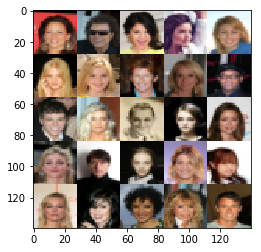

In [19]:
celeba_grid = get_images_grid(celeba_images_preprocessed, CELEBA_IMAGES_NUM, 5, "RGB")
fig, ax = pyplot.subplots(figsize(6))
ax.imshow(celeba_grid)

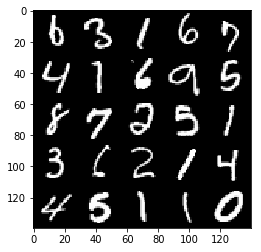

In [20]:
mnist_grid = get_images_grid(mnist_images_preprocessed, MNIST_TRAIN_IMAGES_NUM, 5, "L")
fig, ax = pyplot.subplots()
ax.imshow(mnist_grid, cmap="gray")

### Model

#### Placeholders

In [21]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    input_shape = None, image_width, image_height, image_channels
    input_real = tf.placeholder(tf.float32, shape=input_shape, name="input_real")
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, shape=None, name="learning_rate")
    return input_real, input_z, learning_rate

#### Discriminator

In [22]:
def discriminator(images, reuse=False, is_training=True, leaky_relu_alpha=0.2):
    with tf.variable_scope("discriminator", reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, 2, "SAME", 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(leaky_relu_alpha * x1, x1)  
        
        x2 = tf.layers.conv2d(x1, 128, 5, 2, "SAME",
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_training)
        x2 = tf.maximum(leaky_relu_alpha * x2, x2) 
        
        x3 = tf.layers.conv2d(x2, 256, 5, 2, "SAME",
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_training)
        x3 = tf.maximum(leaky_relu_alpha * x3, x3)  
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits

#### Generator

In [23]:
def generator(z, out_channel_dim, reuse=False, is_training=True, leaky_relu_alpha=0.2): 
    with tf.variable_scope("generator", reuse=reuse):
        x1 = tf.layers.dense(z, 7*7*384)
        x1 = tf.reshape(x1, (-1, 7, 7, 384))
        x1 = tf.layers.batch_normalization(x1, training=is_training)
        x1 = tf.maximum(leaky_relu_alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 192, 5, 2, "SAME",
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_training)
        x2 = tf.maximum(leaky_relu_alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 96, 5, 2, "SAME",
                                        kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_training)
        x3 = tf.maximum(leaky_relu_alpha * x3, x3)
    
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, 1, "SAME",
                                            kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.tanh(logits)
        
        return out

#### Loss

It is important to use logits of discriminator - values before entering sigmoid. Otherwise ther with rounding error when values are close to 0 or 1. 

Good idea is to multiply labels by a little bit smaller that one value. For example 0.9. It's GAN specific method of label smoothing strategy used to regularize normal classifiers. It helps discriminator to generalize better.

In [24]:
def model_loss(input_real, input_z, out_channel_dim, smooth=0.9):
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real) * smooth))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

#### Optimization

In [25]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

#### Batch preparation

In [26]:
def prepare_mini_batches(data, batch_size):
    data_copy = list(data)
    random.shuffle(data_copy)
        
    mini_batches = list()
    while len(data_copy) >= batch_size:
        
        data_batch = list()
        for i in range(0, batch_size):
            data = data_copy.pop()
            data_batch.append(data)
        
        mini_batches.append(np.array(data_batch))
    
    return mini_batches

### Checking model on MNIST

#### Hyperparameters

In [27]:
batch_size = 64
z_dim = 128
learning_rate = 0.0006
beta1 = 0.5
epochs = 3

Epoch 1/3... Discriminator Loss: 0.3616... Generator Loss: 8.3920
Epoch 1/3... Discriminator Loss: 0.9822... Generator Loss: 4.0416
Epoch 1/3... Discriminator Loss: 0.5707... Generator Loss: 3.2617
Epoch 1/3... Discriminator Loss: 0.6038... Generator Loss: 2.5887
Epoch 1/3... Discriminator Loss: 0.4139... Generator Loss: 5.3343
Epoch 1/3... Discriminator Loss: 0.3691... Generator Loss: 4.9630
Epoch 1/3... Discriminator Loss: 1.1637... Generator Loss: 0.9777
Epoch 1/3... Discriminator Loss: 0.7078... Generator Loss: 1.5672
Epoch 1/3... Discriminator Loss: 0.3660... Generator Loss: 4.8489
Epoch 1/3... Discriminator Loss: 0.5919... Generator Loss: 2.3935


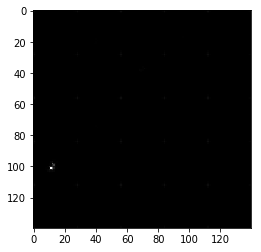

Epoch 1/3... Discriminator Loss: 0.7045... Generator Loss: 1.7931
Epoch 1/3... Discriminator Loss: 0.9030... Generator Loss: 2.3019
Epoch 1/3... Discriminator Loss: 0.9082... Generator Loss: 1.8825
Epoch 1/3... Discriminator Loss: 1.0058... Generator Loss: 1.0465
Epoch 1/3... Discriminator Loss: 1.1060... Generator Loss: 0.9753
Epoch 1/3... Discriminator Loss: 1.1789... Generator Loss: 0.7410
Epoch 1/3... Discriminator Loss: 1.1716... Generator Loss: 1.4640
Epoch 1/3... Discriminator Loss: 1.5430... Generator Loss: 0.4572
Epoch 1/3... Discriminator Loss: 0.9828... Generator Loss: 1.1027
Epoch 1/3... Discriminator Loss: 1.8437... Generator Loss: 0.3374


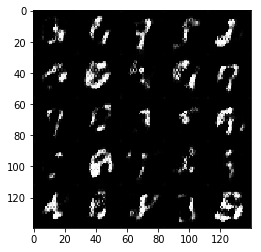

Epoch 1/3... Discriminator Loss: 1.0767... Generator Loss: 0.8469
Epoch 1/3... Discriminator Loss: 1.1647... Generator Loss: 0.8716
Epoch 1/3... Discriminator Loss: 1.3628... Generator Loss: 0.5205
Epoch 1/3... Discriminator Loss: 1.1570... Generator Loss: 0.8687
Epoch 1/3... Discriminator Loss: 1.2665... Generator Loss: 0.6603
Epoch 1/3... Discriminator Loss: 1.5089... Generator Loss: 0.5012
Epoch 1/3... Discriminator Loss: 1.2937... Generator Loss: 0.7055
Epoch 1/3... Discriminator Loss: 1.2107... Generator Loss: 1.0781
Epoch 1/3... Discriminator Loss: 0.9582... Generator Loss: 1.4386
Epoch 1/3... Discriminator Loss: 1.1852... Generator Loss: 1.2041


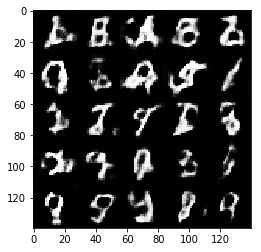

Epoch 1/3... Discriminator Loss: 1.5655... Generator Loss: 0.4095
Epoch 1/3... Discriminator Loss: 1.1726... Generator Loss: 0.8110
Epoch 1/3... Discriminator Loss: 1.3943... Generator Loss: 1.8730
Epoch 1/3... Discriminator Loss: 1.2580... Generator Loss: 1.3647
Epoch 1/3... Discriminator Loss: 1.2621... Generator Loss: 1.6856
Epoch 1/3... Discriminator Loss: 1.3393... Generator Loss: 0.5421
Epoch 1/3... Discriminator Loss: 1.2375... Generator Loss: 0.7629
Epoch 1/3... Discriminator Loss: 1.2457... Generator Loss: 1.5095
Epoch 1/3... Discriminator Loss: 1.1571... Generator Loss: 1.0160
Epoch 1/3... Discriminator Loss: 1.1271... Generator Loss: 1.0055


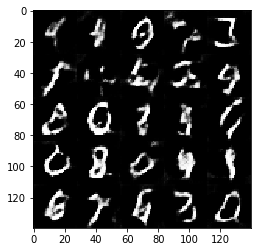

Epoch 1/3... Discriminator Loss: 1.3875... Generator Loss: 0.5717
Epoch 1/3... Discriminator Loss: 1.2079... Generator Loss: 0.6816
Epoch 1/3... Discriminator Loss: 0.9665... Generator Loss: 1.4784
Epoch 1/3... Discriminator Loss: 1.2319... Generator Loss: 1.4659
Epoch 1/3... Discriminator Loss: 1.0384... Generator Loss: 0.9847
Epoch 1/3... Discriminator Loss: 1.1100... Generator Loss: 1.7809
Epoch 1/3... Discriminator Loss: 1.1983... Generator Loss: 0.7067
Epoch 1/3... Discriminator Loss: 1.4128... Generator Loss: 0.5736
Epoch 1/3... Discriminator Loss: 1.1602... Generator Loss: 0.7735
Epoch 1/3... Discriminator Loss: 1.3484... Generator Loss: 0.5914


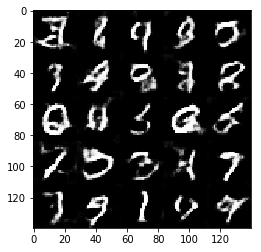

Epoch 1/3... Discriminator Loss: 0.9782... Generator Loss: 1.0316
Epoch 1/3... Discriminator Loss: 1.5015... Generator Loss: 2.2973
Epoch 1/3... Discriminator Loss: 1.0738... Generator Loss: 1.0606
Epoch 1/3... Discriminator Loss: 1.1954... Generator Loss: 0.7145
Epoch 1/3... Discriminator Loss: 1.0906... Generator Loss: 1.0839
Epoch 1/3... Discriminator Loss: 1.2068... Generator Loss: 0.9842
Epoch 1/3... Discriminator Loss: 1.2784... Generator Loss: 0.5800
Epoch 1/3... Discriminator Loss: 1.0272... Generator Loss: 1.2327
Epoch 1/3... Discriminator Loss: 1.2657... Generator Loss: 0.6676
Epoch 1/3... Discriminator Loss: 1.2750... Generator Loss: 2.1740


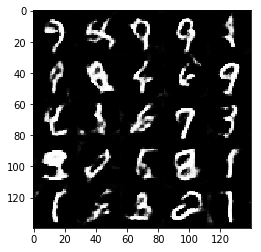

Epoch 1/3... Discriminator Loss: 1.0504... Generator Loss: 1.0066
Epoch 1/3... Discriminator Loss: 1.0148... Generator Loss: 1.1268
Epoch 1/3... Discriminator Loss: 1.5862... Generator Loss: 0.4102
Epoch 1/3... Discriminator Loss: 1.2123... Generator Loss: 0.7028
Epoch 1/3... Discriminator Loss: 1.0704... Generator Loss: 1.6290
Epoch 1/3... Discriminator Loss: 1.1778... Generator Loss: 0.8617
Epoch 1/3... Discriminator Loss: 1.0909... Generator Loss: 1.4175
Epoch 1/3... Discriminator Loss: 1.2295... Generator Loss: 1.4784
Epoch 1/3... Discriminator Loss: 1.2393... Generator Loss: 0.6899
Epoch 1/3... Discriminator Loss: 1.2133... Generator Loss: 1.3045


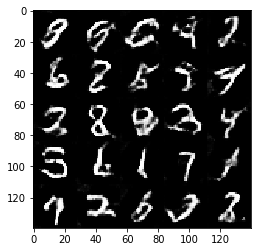

Epoch 1/3... Discriminator Loss: 1.1583... Generator Loss: 1.7990
Epoch 1/3... Discriminator Loss: 1.6144... Generator Loss: 0.4082
Epoch 1/3... Discriminator Loss: 1.0262... Generator Loss: 1.0239
Epoch 1/3... Discriminator Loss: 1.1467... Generator Loss: 0.7196
Epoch 1/3... Discriminator Loss: 2.0103... Generator Loss: 0.2634
Epoch 1/3... Discriminator Loss: 1.0667... Generator Loss: 0.8419
Epoch 1/3... Discriminator Loss: 1.0966... Generator Loss: 0.8500
Epoch 1/3... Discriminator Loss: 1.0473... Generator Loss: 1.2066
Epoch 1/3... Discriminator Loss: 0.9891... Generator Loss: 1.2431
Epoch 1/3... Discriminator Loss: 2.4657... Generator Loss: 0.1808


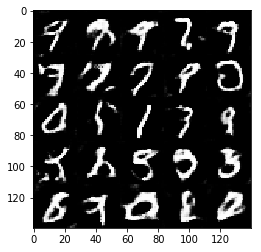

Epoch 1/3... Discriminator Loss: 1.1154... Generator Loss: 0.9927
Epoch 1/3... Discriminator Loss: 1.3216... Generator Loss: 0.6798
Epoch 1/3... Discriminator Loss: 1.0782... Generator Loss: 1.3504
Epoch 1/3... Discriminator Loss: 1.1972... Generator Loss: 1.3897
Epoch 1/3... Discriminator Loss: 1.1495... Generator Loss: 0.7713
Epoch 1/3... Discriminator Loss: 0.9560... Generator Loss: 1.2816
Epoch 1/3... Discriminator Loss: 1.0523... Generator Loss: 1.0162
Epoch 1/3... Discriminator Loss: 1.1318... Generator Loss: 0.8490
Epoch 1/3... Discriminator Loss: 1.0319... Generator Loss: 1.3917
Epoch 1/3... Discriminator Loss: 1.1358... Generator Loss: 0.7665


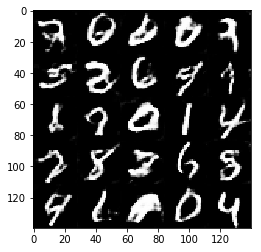

Epoch 1/3... Discriminator Loss: 1.1418... Generator Loss: 0.7627
Epoch 1/3... Discriminator Loss: 1.0419... Generator Loss: 0.9366
Epoch 1/3... Discriminator Loss: 1.6159... Generator Loss: 0.3784
Epoch 2/3... Discriminator Loss: 1.0758... Generator Loss: 0.8895
Epoch 2/3... Discriminator Loss: 1.1216... Generator Loss: 0.7564
Epoch 2/3... Discriminator Loss: 1.1642... Generator Loss: 0.7753
Epoch 2/3... Discriminator Loss: 1.2344... Generator Loss: 0.7486
Epoch 2/3... Discriminator Loss: 1.4735... Generator Loss: 0.5347
Epoch 2/3... Discriminator Loss: 1.0311... Generator Loss: 1.2248
Epoch 2/3... Discriminator Loss: 1.4088... Generator Loss: 0.5475


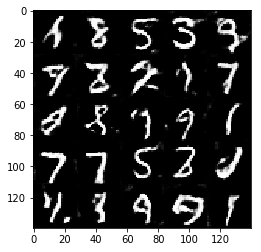

Epoch 2/3... Discriminator Loss: 1.0709... Generator Loss: 1.0497
Epoch 2/3... Discriminator Loss: 1.2830... Generator Loss: 0.6874
Epoch 2/3... Discriminator Loss: 1.1514... Generator Loss: 1.1145
Epoch 2/3... Discriminator Loss: 1.3039... Generator Loss: 0.6471
Epoch 2/3... Discriminator Loss: 1.1440... Generator Loss: 0.7312
Epoch 2/3... Discriminator Loss: 0.9633... Generator Loss: 0.9109
Epoch 2/3... Discriminator Loss: 1.5298... Generator Loss: 0.4685
Epoch 2/3... Discriminator Loss: 1.0003... Generator Loss: 1.0095
Epoch 2/3... Discriminator Loss: 1.0885... Generator Loss: 0.9184
Epoch 2/3... Discriminator Loss: 0.9614... Generator Loss: 1.0794


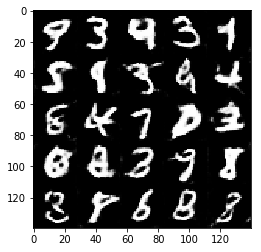

Epoch 2/3... Discriminator Loss: 1.1217... Generator Loss: 0.7191
Epoch 2/3... Discriminator Loss: 1.1256... Generator Loss: 0.8399
Epoch 2/3... Discriminator Loss: 1.0524... Generator Loss: 0.8777
Epoch 2/3... Discriminator Loss: 1.0329... Generator Loss: 0.8764
Epoch 2/3... Discriminator Loss: 1.0037... Generator Loss: 0.9278
Epoch 2/3... Discriminator Loss: 1.4327... Generator Loss: 0.5534
Epoch 2/3... Discriminator Loss: 1.0460... Generator Loss: 1.1251
Epoch 2/3... Discriminator Loss: 1.2077... Generator Loss: 0.7710
Epoch 2/3... Discriminator Loss: 1.3302... Generator Loss: 0.6324
Epoch 2/3... Discriminator Loss: 1.1102... Generator Loss: 0.8315


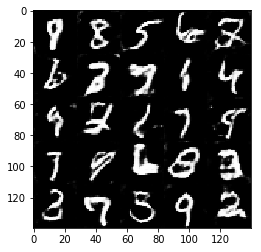

Epoch 2/3... Discriminator Loss: 0.9706... Generator Loss: 1.5091
Epoch 2/3... Discriminator Loss: 0.8698... Generator Loss: 1.4622
Epoch 2/3... Discriminator Loss: 1.0769... Generator Loss: 0.8249
Epoch 2/3... Discriminator Loss: 1.6122... Generator Loss: 0.5772
Epoch 2/3... Discriminator Loss: 1.2773... Generator Loss: 1.7798
Epoch 2/3... Discriminator Loss: 1.0543... Generator Loss: 0.8953
Epoch 2/3... Discriminator Loss: 1.3705... Generator Loss: 0.5531
Epoch 2/3... Discriminator Loss: 1.3352... Generator Loss: 0.6917
Epoch 2/3... Discriminator Loss: 0.9675... Generator Loss: 1.1498
Epoch 2/3... Discriminator Loss: 1.0936... Generator Loss: 0.8015


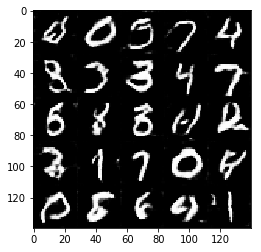

Epoch 2/3... Discriminator Loss: 1.1530... Generator Loss: 0.7057
Epoch 2/3... Discriminator Loss: 1.0596... Generator Loss: 0.9363
Epoch 2/3... Discriminator Loss: 1.2307... Generator Loss: 0.6971
Epoch 2/3... Discriminator Loss: 1.2105... Generator Loss: 0.7466
Epoch 2/3... Discriminator Loss: 0.9509... Generator Loss: 1.0980
Epoch 2/3... Discriminator Loss: 0.8284... Generator Loss: 1.7468
Epoch 2/3... Discriminator Loss: 0.8891... Generator Loss: 1.3609
Epoch 2/3... Discriminator Loss: 0.8222... Generator Loss: 1.5188
Epoch 2/3... Discriminator Loss: 2.0822... Generator Loss: 0.3228
Epoch 2/3... Discriminator Loss: 1.0020... Generator Loss: 0.9742


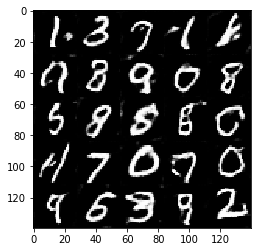

Epoch 2/3... Discriminator Loss: 0.8169... Generator Loss: 1.7277
Epoch 2/3... Discriminator Loss: 1.1069... Generator Loss: 0.7537
Epoch 2/3... Discriminator Loss: 0.9469... Generator Loss: 1.3543
Epoch 2/3... Discriminator Loss: 1.3262... Generator Loss: 0.5628
Epoch 2/3... Discriminator Loss: 1.3943... Generator Loss: 0.5377
Epoch 2/3... Discriminator Loss: 1.0201... Generator Loss: 0.9466
Epoch 2/3... Discriminator Loss: 1.2935... Generator Loss: 1.5593
Epoch 2/3... Discriminator Loss: 1.1217... Generator Loss: 1.7050
Epoch 2/3... Discriminator Loss: 1.3551... Generator Loss: 0.5325
Epoch 2/3... Discriminator Loss: 0.9752... Generator Loss: 0.9463


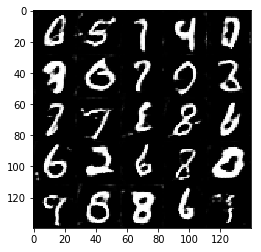

Epoch 2/3... Discriminator Loss: 0.8087... Generator Loss: 1.4318
Epoch 2/3... Discriminator Loss: 0.8583... Generator Loss: 1.8992
Epoch 2/3... Discriminator Loss: 1.0826... Generator Loss: 1.1255
Epoch 2/3... Discriminator Loss: 1.3393... Generator Loss: 0.6013
Epoch 2/3... Discriminator Loss: 0.7344... Generator Loss: 1.5680
Epoch 2/3... Discriminator Loss: 1.4638... Generator Loss: 0.6279
Epoch 2/3... Discriminator Loss: 1.0203... Generator Loss: 0.9625
Epoch 2/3... Discriminator Loss: 0.9408... Generator Loss: 1.2989
Epoch 2/3... Discriminator Loss: 0.6994... Generator Loss: 1.8708
Epoch 2/3... Discriminator Loss: 0.7002... Generator Loss: 1.5054


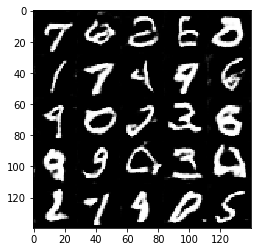

Epoch 2/3... Discriminator Loss: 0.9114... Generator Loss: 2.3358
Epoch 2/3... Discriminator Loss: 1.1868... Generator Loss: 0.7696
Epoch 2/3... Discriminator Loss: 1.3115... Generator Loss: 0.6170
Epoch 2/3... Discriminator Loss: 1.1754... Generator Loss: 0.7614
Epoch 2/3... Discriminator Loss: 1.2140... Generator Loss: 0.6964
Epoch 2/3... Discriminator Loss: 1.0499... Generator Loss: 0.8877
Epoch 2/3... Discriminator Loss: 1.6793... Generator Loss: 0.3806
Epoch 2/3... Discriminator Loss: 1.0331... Generator Loss: 0.8505
Epoch 2/3... Discriminator Loss: 1.4563... Generator Loss: 0.5017
Epoch 2/3... Discriminator Loss: 1.2798... Generator Loss: 0.6915


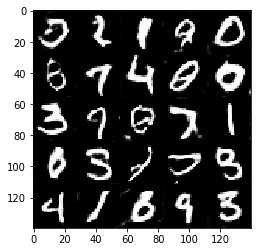

Epoch 2/3... Discriminator Loss: 1.1675... Generator Loss: 0.8591
Epoch 2/3... Discriminator Loss: 0.6481... Generator Loss: 1.6245
Epoch 2/3... Discriminator Loss: 1.1604... Generator Loss: 0.7788
Epoch 2/3... Discriminator Loss: 1.2986... Generator Loss: 0.6182
Epoch 2/3... Discriminator Loss: 1.0338... Generator Loss: 1.0232
Epoch 2/3... Discriminator Loss: 1.2990... Generator Loss: 0.6380
Epoch 2/3... Discriminator Loss: 0.9749... Generator Loss: 1.1887
Epoch 2/3... Discriminator Loss: 0.6862... Generator Loss: 1.8175
Epoch 2/3... Discriminator Loss: 1.6778... Generator Loss: 0.4355
Epoch 2/3... Discriminator Loss: 0.9946... Generator Loss: 1.0061


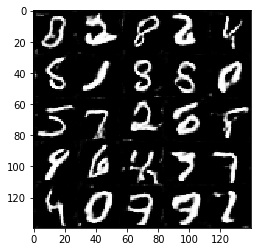

Epoch 2/3... Discriminator Loss: 0.9027... Generator Loss: 1.3421
Epoch 2/3... Discriminator Loss: 0.7401... Generator Loss: 2.0680
Epoch 2/3... Discriminator Loss: 0.9157... Generator Loss: 1.0179
Epoch 2/3... Discriminator Loss: 0.8486... Generator Loss: 1.3952
Epoch 2/3... Discriminator Loss: 1.4193... Generator Loss: 0.5298
Epoch 2/3... Discriminator Loss: 1.0154... Generator Loss: 0.9687
Epoch 2/3... Discriminator Loss: 1.1611... Generator Loss: 0.8009
Epoch 3/3... Discriminator Loss: 0.7032... Generator Loss: 2.1117
Epoch 3/3... Discriminator Loss: 1.7429... Generator Loss: 0.4549
Epoch 3/3... Discriminator Loss: 1.5241... Generator Loss: 0.4964


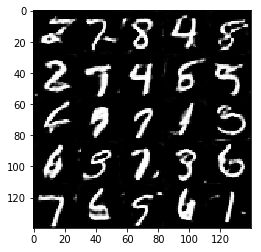

Epoch 3/3... Discriminator Loss: 1.4848... Generator Loss: 0.5151
Epoch 3/3... Discriminator Loss: 1.0699... Generator Loss: 1.0416
Epoch 3/3... Discriminator Loss: 0.9537... Generator Loss: 1.3588
Epoch 3/3... Discriminator Loss: 0.9819... Generator Loss: 1.3144
Epoch 3/3... Discriminator Loss: 0.9819... Generator Loss: 0.9584
Epoch 3/3... Discriminator Loss: 1.0042... Generator Loss: 0.9290
Epoch 3/3... Discriminator Loss: 0.7428... Generator Loss: 1.7312
Epoch 3/3... Discriminator Loss: 0.8774... Generator Loss: 2.2639
Epoch 3/3... Discriminator Loss: 1.0307... Generator Loss: 1.8236
Epoch 3/3... Discriminator Loss: 2.2551... Generator Loss: 0.2343


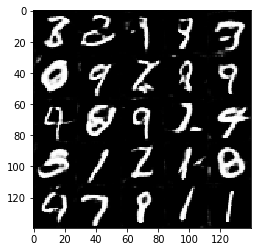

Epoch 3/3... Discriminator Loss: 0.6335... Generator Loss: 1.6500
Epoch 3/3... Discriminator Loss: 1.1194... Generator Loss: 1.2732
Epoch 3/3... Discriminator Loss: 1.0179... Generator Loss: 1.1125
Epoch 3/3... Discriminator Loss: 0.8124... Generator Loss: 1.3853
Epoch 3/3... Discriminator Loss: 0.7660... Generator Loss: 1.3000
Epoch 3/3... Discriminator Loss: 1.5881... Generator Loss: 0.4496
Epoch 3/3... Discriminator Loss: 1.1116... Generator Loss: 0.8299
Epoch 3/3... Discriminator Loss: 1.1139... Generator Loss: 0.8169
Epoch 3/3... Discriminator Loss: 1.0006... Generator Loss: 1.0523
Epoch 3/3... Discriminator Loss: 0.9366... Generator Loss: 1.1225


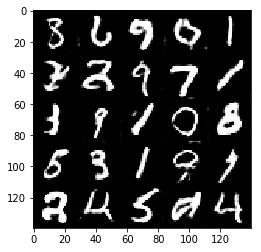

Epoch 3/3... Discriminator Loss: 0.9573... Generator Loss: 0.9214
Epoch 3/3... Discriminator Loss: 0.8367... Generator Loss: 1.4398
Epoch 3/3... Discriminator Loss: 0.9195... Generator Loss: 1.0035
Epoch 3/3... Discriminator Loss: 0.8639... Generator Loss: 1.5271
Epoch 3/3... Discriminator Loss: 0.8587... Generator Loss: 1.0894
Epoch 3/3... Discriminator Loss: 1.3577... Generator Loss: 0.9620
Epoch 3/3... Discriminator Loss: 1.0653... Generator Loss: 1.9802
Epoch 3/3... Discriminator Loss: 0.7302... Generator Loss: 2.1814
Epoch 3/3... Discriminator Loss: 0.8080... Generator Loss: 1.7134
Epoch 3/3... Discriminator Loss: 0.8674... Generator Loss: 1.2373


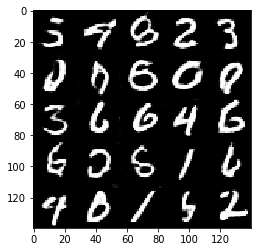

Epoch 3/3... Discriminator Loss: 0.9824... Generator Loss: 1.8353
Epoch 3/3... Discriminator Loss: 0.8745... Generator Loss: 1.1275
Epoch 3/3... Discriminator Loss: 1.0739... Generator Loss: 0.8249
Epoch 3/3... Discriminator Loss: 0.8906... Generator Loss: 1.2779
Epoch 3/3... Discriminator Loss: 1.0743... Generator Loss: 0.8564
Epoch 3/3... Discriminator Loss: 0.8244... Generator Loss: 1.4539
Epoch 3/3... Discriminator Loss: 0.9421... Generator Loss: 1.0989
Epoch 3/3... Discriminator Loss: 0.7654... Generator Loss: 1.8190
Epoch 3/3... Discriminator Loss: 1.3176... Generator Loss: 0.6408
Epoch 3/3... Discriminator Loss: 0.8456... Generator Loss: 1.2192


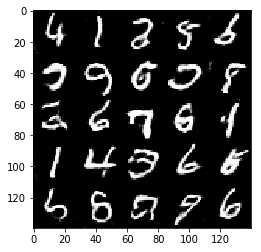

Epoch 3/3... Discriminator Loss: 1.4034... Generator Loss: 0.5573
Epoch 3/3... Discriminator Loss: 0.8233... Generator Loss: 1.1574
Epoch 3/3... Discriminator Loss: 0.6853... Generator Loss: 1.5119
Epoch 3/3... Discriminator Loss: 1.1536... Generator Loss: 0.7589
Epoch 3/3... Discriminator Loss: 1.2281... Generator Loss: 0.7325
Epoch 3/3... Discriminator Loss: 0.8776... Generator Loss: 1.3638
Epoch 3/3... Discriminator Loss: 0.9188... Generator Loss: 1.3406
Epoch 3/3... Discriminator Loss: 0.7565... Generator Loss: 1.4100
Epoch 3/3... Discriminator Loss: 1.0161... Generator Loss: 0.8883
Epoch 3/3... Discriminator Loss: 0.8476... Generator Loss: 1.5413


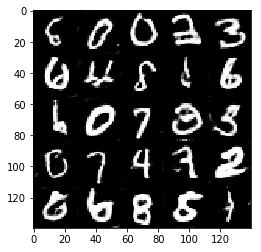

Epoch 3/3... Discriminator Loss: 0.8065... Generator Loss: 1.2691
Epoch 3/3... Discriminator Loss: 1.2457... Generator Loss: 0.6728
Epoch 3/3... Discriminator Loss: 0.9701... Generator Loss: 0.9620
Epoch 3/3... Discriminator Loss: 1.0115... Generator Loss: 0.9091
Epoch 3/3... Discriminator Loss: 0.8771... Generator Loss: 1.2527
Epoch 3/3... Discriminator Loss: 0.9454... Generator Loss: 1.3575
Epoch 3/3... Discriminator Loss: 0.9703... Generator Loss: 1.0530
Epoch 3/3... Discriminator Loss: 1.0541... Generator Loss: 2.6183
Epoch 3/3... Discriminator Loss: 0.9473... Generator Loss: 0.9867
Epoch 3/3... Discriminator Loss: 1.1645... Generator Loss: 0.7762


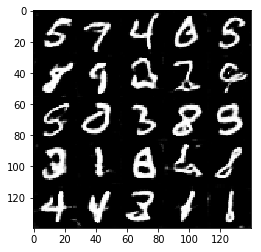

Epoch 3/3... Discriminator Loss: 1.3026... Generator Loss: 0.6831
Epoch 3/3... Discriminator Loss: 1.0094... Generator Loss: 1.0063
Epoch 3/3... Discriminator Loss: 1.4054... Generator Loss: 2.5144
Epoch 3/3... Discriminator Loss: 0.7078... Generator Loss: 1.4257
Epoch 3/3... Discriminator Loss: 1.0317... Generator Loss: 0.8732
Epoch 3/3... Discriminator Loss: 0.9382... Generator Loss: 0.9759
Epoch 3/3... Discriminator Loss: 0.9544... Generator Loss: 1.1631
Epoch 3/3... Discriminator Loss: 1.6986... Generator Loss: 0.4109
Epoch 3/3... Discriminator Loss: 2.2555... Generator Loss: 0.2817
Epoch 3/3... Discriminator Loss: 1.0708... Generator Loss: 0.8474


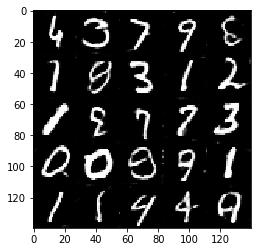

Epoch 3/3... Discriminator Loss: 1.1388... Generator Loss: 0.8873
Epoch 3/3... Discriminator Loss: 1.4086... Generator Loss: 0.6492
Epoch 3/3... Discriminator Loss: 1.5514... Generator Loss: 0.5444
Epoch 3/3... Discriminator Loss: 0.8083... Generator Loss: 1.9138
Epoch 3/3... Discriminator Loss: 1.4651... Generator Loss: 0.5057
Epoch 3/3... Discriminator Loss: 1.6044... Generator Loss: 0.4463
Epoch 3/3... Discriminator Loss: 0.9631... Generator Loss: 1.1502
Epoch 3/3... Discriminator Loss: 0.7626... Generator Loss: 1.9937
Epoch 3/3... Discriminator Loss: 0.9079... Generator Loss: 2.5824
Epoch 3/3... Discriminator Loss: 1.6849... Generator Loss: 0.5193


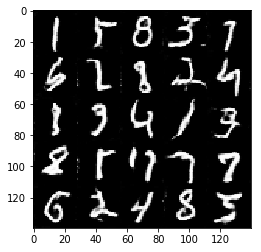

Epoch 3/3... Discriminator Loss: 1.9217... Generator Loss: 0.3214
Epoch 3/3... Discriminator Loss: 1.0591... Generator Loss: 2.2724
Epoch 3/3... Discriminator Loss: 1.0131... Generator Loss: 1.1199
Epoch 3/3... Discriminator Loss: 1.2077... Generator Loss: 0.9896
Epoch 3/3... Discriminator Loss: 1.0554... Generator Loss: 0.9073
Epoch 3/3... Discriminator Loss: 1.2111... Generator Loss: 2.5444
Epoch 3/3... Discriminator Loss: 0.8325... Generator Loss: 1.5068
Epoch 3/3... Discriminator Loss: 0.9411... Generator Loss: 1.4885
Epoch 3/3... Discriminator Loss: 0.8503... Generator Loss: 1.1849
Epoch 3/3... Discriminator Loss: 1.5685... Generator Loss: 0.4899


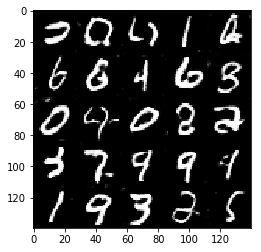

Epoch 3/3... Discriminator Loss: 1.6116... Generator Loss: 0.5152


In [28]:
with tf.Graph().as_default():
    
    input_real, input_z, lr = model_inputs(MNIST_IMAGE_WIDTH, MNIST_IMAGE_HEIGHT, 
                                           MNIST_NUM_CHANNELS, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, MNIST_NUM_CHANNELS)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1) 
    
    steps=0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epochs):
            
            mini_batches = prepare_mini_batches(mnist_images_preprocessed, batch_size)
            while mini_batches:
                steps += 1
                
                batch_d = mini_batches.pop()
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
           
                _ = sess.run(d_train_opt, 
                             feed_dict={input_real: batch_d, 
                                        input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, 
                             feed_dict={input_real: batch_d, 
                                        input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_d, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format((epoch_i + 1), epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    example_input = np.random.uniform(-1, 1, size=[25, z_dim])

                    generated_samples = sess.run(
                        generator(input_z, MNIST_NUM_CHANNELS, 
                                  reuse=True, is_training=False), 
                        feed_dict={input_z: example_input})

                    generated_samples_grid = get_images_grid(
                        generated_samples, len(generated_samples), 5, "L")

                    pyplot.imshow(generated_samples_grid, cmap="gray")
                    pyplot.show()

### Generating human faces

In [29]:
batch_size = 64
z_dim = 128
learning_rate = 0.0006
beta1 = 0.5
epochs = 2

Epoch 1/2... Discriminator Loss: 0.5390... Generator Loss: 21.7792
Epoch 1/2... Discriminator Loss: 4.4159... Generator Loss: 0.0239
Epoch 1/2... Discriminator Loss: 0.4059... Generator Loss: 5.6003
Epoch 1/2... Discriminator Loss: 0.4274... Generator Loss: 6.5614
Epoch 1/2... Discriminator Loss: 0.5495... Generator Loss: 3.7362
Epoch 1/2... Discriminator Loss: 0.8945... Generator Loss: 1.6098
Epoch 1/2... Discriminator Loss: 1.2640... Generator Loss: 0.7459
Epoch 1/2... Discriminator Loss: 1.0801... Generator Loss: 1.3779
Epoch 1/2... Discriminator Loss: 1.0244... Generator Loss: 1.1745
Epoch 1/2... Discriminator Loss: 0.8794... Generator Loss: 2.8657


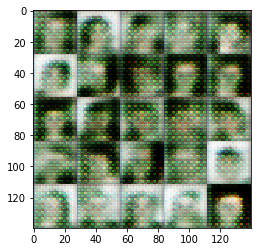

Epoch 1/2... Discriminator Loss: 1.3387... Generator Loss: 2.4498
Epoch 1/2... Discriminator Loss: 1.2771... Generator Loss: 0.9619
Epoch 1/2... Discriminator Loss: 1.2309... Generator Loss: 0.9948
Epoch 1/2... Discriminator Loss: 1.6667... Generator Loss: 0.9270
Epoch 1/2... Discriminator Loss: 1.4603... Generator Loss: 0.7155
Epoch 1/2... Discriminator Loss: 1.4024... Generator Loss: 1.0289
Epoch 1/2... Discriminator Loss: 1.5872... Generator Loss: 0.5119
Epoch 1/2... Discriminator Loss: 1.3618... Generator Loss: 0.8244
Epoch 1/2... Discriminator Loss: 1.3370... Generator Loss: 1.7127
Epoch 1/2... Discriminator Loss: 1.4784... Generator Loss: 1.5220


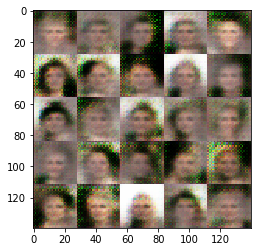

Epoch 1/2... Discriminator Loss: 1.2897... Generator Loss: 0.8864
Epoch 1/2... Discriminator Loss: 1.3457... Generator Loss: 0.8433
Epoch 1/2... Discriminator Loss: 1.4032... Generator Loss: 0.7848
Epoch 1/2... Discriminator Loss: 1.3481... Generator Loss: 0.8342
Epoch 1/2... Discriminator Loss: 1.4669... Generator Loss: 0.7957
Epoch 1/2... Discriminator Loss: 1.5285... Generator Loss: 0.6999
Epoch 1/2... Discriminator Loss: 1.4215... Generator Loss: 0.6586
Epoch 1/2... Discriminator Loss: 1.2519... Generator Loss: 0.9385
Epoch 1/2... Discriminator Loss: 1.6275... Generator Loss: 0.5646
Epoch 1/2... Discriminator Loss: 1.4641... Generator Loss: 0.6684


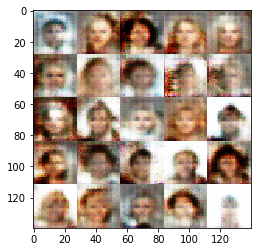

Epoch 1/2... Discriminator Loss: 1.4259... Generator Loss: 0.7804
Epoch 1/2... Discriminator Loss: 1.4895... Generator Loss: 0.9326
Epoch 1/2... Discriminator Loss: 1.4492... Generator Loss: 0.6696
Epoch 1/2... Discriminator Loss: 1.4115... Generator Loss: 0.7369
Epoch 1/2... Discriminator Loss: 1.2065... Generator Loss: 0.7134
Epoch 1/2... Discriminator Loss: 1.5119... Generator Loss: 0.6979
Epoch 1/2... Discriminator Loss: 1.4031... Generator Loss: 0.8979
Epoch 1/2... Discriminator Loss: 1.1124... Generator Loss: 1.4016
Epoch 1/2... Discriminator Loss: 1.2359... Generator Loss: 0.7172
Epoch 1/2... Discriminator Loss: 1.3680... Generator Loss: 0.6044


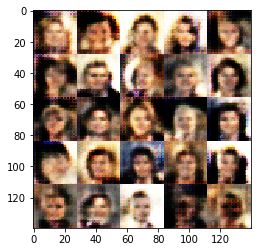

Epoch 1/2... Discriminator Loss: 1.2523... Generator Loss: 0.6715
Epoch 1/2... Discriminator Loss: 2.0252... Generator Loss: 0.3863
Epoch 1/2... Discriminator Loss: 1.7676... Generator Loss: 0.9679
Epoch 1/2... Discriminator Loss: 1.4360... Generator Loss: 0.6972
Epoch 1/2... Discriminator Loss: 1.3961... Generator Loss: 0.8062
Epoch 1/2... Discriminator Loss: 1.3392... Generator Loss: 0.7901
Epoch 1/2... Discriminator Loss: 1.3131... Generator Loss: 1.1924
Epoch 1/2... Discriminator Loss: 1.1767... Generator Loss: 0.7018
Epoch 1/2... Discriminator Loss: 1.1641... Generator Loss: 1.1790
Epoch 1/2... Discriminator Loss: 1.3486... Generator Loss: 0.8919


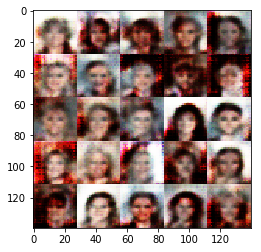

Epoch 1/2... Discriminator Loss: 1.2395... Generator Loss: 1.1255
Epoch 1/2... Discriminator Loss: 1.2515... Generator Loss: 0.7303
Epoch 1/2... Discriminator Loss: 1.5594... Generator Loss: 0.6516
Epoch 1/2... Discriminator Loss: 1.2763... Generator Loss: 0.7550
Epoch 1/2... Discriminator Loss: 1.2313... Generator Loss: 1.1047
Epoch 1/2... Discriminator Loss: 1.2698... Generator Loss: 1.1774
Epoch 1/2... Discriminator Loss: 0.9826... Generator Loss: 1.1581
Epoch 1/2... Discriminator Loss: 1.5785... Generator Loss: 0.5136
Epoch 1/2... Discriminator Loss: 1.2394... Generator Loss: 0.6871
Epoch 1/2... Discriminator Loss: 1.3449... Generator Loss: 0.9774


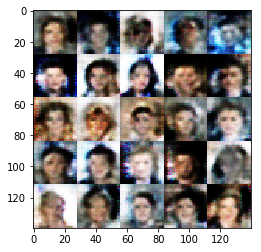

Epoch 1/2... Discriminator Loss: 1.4269... Generator Loss: 1.2283
Epoch 1/2... Discriminator Loss: 1.4368... Generator Loss: 0.7401
Epoch 1/2... Discriminator Loss: 1.3650... Generator Loss: 0.5796
Epoch 1/2... Discriminator Loss: 1.2211... Generator Loss: 0.8090
Epoch 1/2... Discriminator Loss: 1.3919... Generator Loss: 0.7193
Epoch 1/2... Discriminator Loss: 1.3956... Generator Loss: 0.7147
Epoch 1/2... Discriminator Loss: 1.1907... Generator Loss: 0.9731
Epoch 1/2... Discriminator Loss: 1.3290... Generator Loss: 0.8981
Epoch 1/2... Discriminator Loss: 1.2735... Generator Loss: 0.6959
Epoch 1/2... Discriminator Loss: 1.3874... Generator Loss: 0.7934


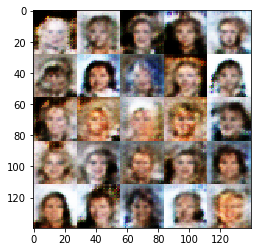

Epoch 1/2... Discriminator Loss: 1.2488... Generator Loss: 0.8254
Epoch 1/2... Discriminator Loss: 1.3810... Generator Loss: 0.6462
Epoch 1/2... Discriminator Loss: 1.2687... Generator Loss: 0.9961
Epoch 1/2... Discriminator Loss: 1.3141... Generator Loss: 0.7287
Epoch 1/2... Discriminator Loss: 1.3607... Generator Loss: 1.0069
Epoch 1/2... Discriminator Loss: 1.1327... Generator Loss: 0.7327
Epoch 1/2... Discriminator Loss: 1.2807... Generator Loss: 0.7083
Epoch 1/2... Discriminator Loss: 1.4112... Generator Loss: 0.7538
Epoch 1/2... Discriminator Loss: 1.3052... Generator Loss: 0.8824
Epoch 1/2... Discriminator Loss: 1.3340... Generator Loss: 1.0428


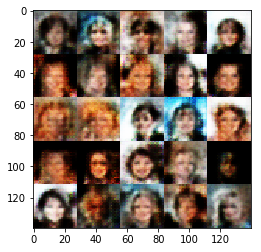

Epoch 1/2... Discriminator Loss: 1.3389... Generator Loss: 0.8026
Epoch 1/2... Discriminator Loss: 1.1237... Generator Loss: 0.8430
Epoch 1/2... Discriminator Loss: 1.3344... Generator Loss: 0.7304
Epoch 1/2... Discriminator Loss: 1.6135... Generator Loss: 1.0681
Epoch 1/2... Discriminator Loss: 1.4525... Generator Loss: 0.5385
Epoch 1/2... Discriminator Loss: 1.3392... Generator Loss: 0.9101
Epoch 1/2... Discriminator Loss: 1.3687... Generator Loss: 1.0355
Epoch 1/2... Discriminator Loss: 1.5256... Generator Loss: 0.4936
Epoch 1/2... Discriminator Loss: 1.3506... Generator Loss: 0.8595
Epoch 1/2... Discriminator Loss: 1.4958... Generator Loss: 0.5162


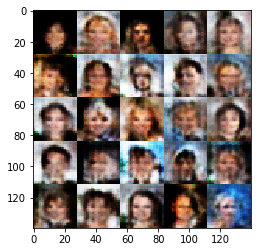

Epoch 1/2... Discriminator Loss: 1.6611... Generator Loss: 1.5645
Epoch 1/2... Discriminator Loss: 1.1944... Generator Loss: 0.7280
Epoch 1/2... Discriminator Loss: 1.3248... Generator Loss: 1.2071
Epoch 1/2... Discriminator Loss: 1.9910... Generator Loss: 2.3314
Epoch 1/2... Discriminator Loss: 1.1986... Generator Loss: 1.0723
Epoch 1/2... Discriminator Loss: 1.3537... Generator Loss: 0.6968
Epoch 1/2... Discriminator Loss: 1.4910... Generator Loss: 1.1499
Epoch 1/2... Discriminator Loss: 1.3268... Generator Loss: 0.8578
Epoch 1/2... Discriminator Loss: 1.4549... Generator Loss: 1.0206
Epoch 1/2... Discriminator Loss: 1.2805... Generator Loss: 1.1980


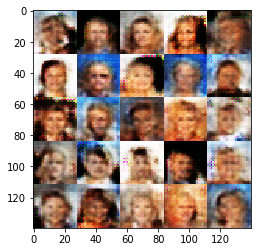

Epoch 1/2... Discriminator Loss: 1.3464... Generator Loss: 0.8906
Epoch 1/2... Discriminator Loss: 1.4190... Generator Loss: 0.7766
Epoch 1/2... Discriminator Loss: 1.2485... Generator Loss: 0.9078
Epoch 1/2... Discriminator Loss: 1.2799... Generator Loss: 0.9612
Epoch 1/2... Discriminator Loss: 1.1026... Generator Loss: 0.8203
Epoch 1/2... Discriminator Loss: 1.2991... Generator Loss: 0.9523
Epoch 1/2... Discriminator Loss: 1.4589... Generator Loss: 1.4384
Epoch 1/2... Discriminator Loss: 1.2943... Generator Loss: 0.8912
Epoch 1/2... Discriminator Loss: 1.3528... Generator Loss: 0.7412
Epoch 1/2... Discriminator Loss: 1.5747... Generator Loss: 0.3937


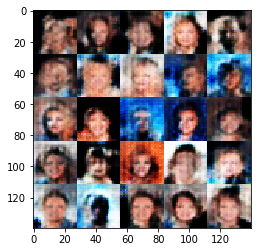

Epoch 1/2... Discriminator Loss: 1.2047... Generator Loss: 0.9189
Epoch 1/2... Discriminator Loss: 1.2637... Generator Loss: 1.0826
Epoch 1/2... Discriminator Loss: 1.2818... Generator Loss: 1.0709
Epoch 1/2... Discriminator Loss: 1.3435... Generator Loss: 0.7624
Epoch 1/2... Discriminator Loss: 1.1690... Generator Loss: 0.9287
Epoch 1/2... Discriminator Loss: 1.3558... Generator Loss: 0.7476
Epoch 1/2... Discriminator Loss: 1.4633... Generator Loss: 0.6181
Epoch 1/2... Discriminator Loss: 1.3745... Generator Loss: 0.6649
Epoch 1/2... Discriminator Loss: 1.2625... Generator Loss: 0.8112
Epoch 1/2... Discriminator Loss: 1.3420... Generator Loss: 0.7799


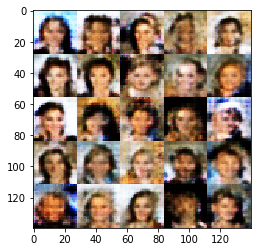

Epoch 1/2... Discriminator Loss: 1.2041... Generator Loss: 0.8014
Epoch 1/2... Discriminator Loss: 1.4437... Generator Loss: 0.6387
Epoch 1/2... Discriminator Loss: 1.4232... Generator Loss: 1.1273
Epoch 1/2... Discriminator Loss: 1.3176... Generator Loss: 0.9452
Epoch 1/2... Discriminator Loss: 1.4405... Generator Loss: 0.5616
Epoch 1/2... Discriminator Loss: 1.7359... Generator Loss: 0.3363
Epoch 1/2... Discriminator Loss: 1.4726... Generator Loss: 0.5956
Epoch 1/2... Discriminator Loss: 1.2762... Generator Loss: 0.8001
Epoch 1/2... Discriminator Loss: 1.5823... Generator Loss: 0.4784
Epoch 1/2... Discriminator Loss: 1.2177... Generator Loss: 0.8599


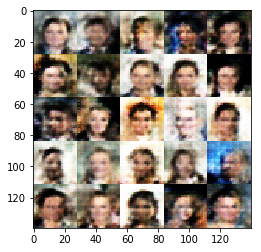

Epoch 1/2... Discriminator Loss: 1.3390... Generator Loss: 0.6739
Epoch 1/2... Discriminator Loss: 1.5020... Generator Loss: 1.3136
Epoch 1/2... Discriminator Loss: 1.3916... Generator Loss: 1.2301
Epoch 1/2... Discriminator Loss: 1.4594... Generator Loss: 0.8035
Epoch 1/2... Discriminator Loss: 1.3189... Generator Loss: 0.9573
Epoch 1/2... Discriminator Loss: 1.3183... Generator Loss: 0.6355
Epoch 1/2... Discriminator Loss: 1.4025... Generator Loss: 0.6393
Epoch 1/2... Discriminator Loss: 1.2936... Generator Loss: 1.2088
Epoch 1/2... Discriminator Loss: 1.3206... Generator Loss: 0.9037
Epoch 1/2... Discriminator Loss: 1.3360... Generator Loss: 0.7276


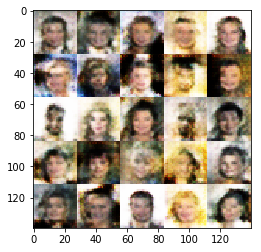

Epoch 1/2... Discriminator Loss: 1.3300... Generator Loss: 1.2563
Epoch 1/2... Discriminator Loss: 1.2609... Generator Loss: 0.8136
Epoch 1/2... Discriminator Loss: 1.3075... Generator Loss: 0.8509
Epoch 1/2... Discriminator Loss: 0.9691... Generator Loss: 0.9708
Epoch 1/2... Discriminator Loss: 1.5248... Generator Loss: 1.6091
Epoch 1/2... Discriminator Loss: 1.2356... Generator Loss: 0.7796
Epoch 1/2... Discriminator Loss: 1.2093... Generator Loss: 0.8433
Epoch 1/2... Discriminator Loss: 1.2996... Generator Loss: 0.8618
Epoch 1/2... Discriminator Loss: 1.3372... Generator Loss: 0.8446
Epoch 1/2... Discriminator Loss: 1.0977... Generator Loss: 1.0328


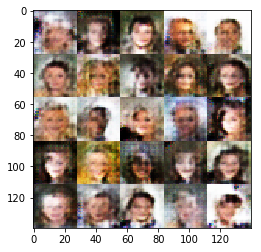

Epoch 1/2... Discriminator Loss: 1.2399... Generator Loss: 0.8657
Epoch 1/2... Discriminator Loss: 1.2839... Generator Loss: 1.0171
Epoch 1/2... Discriminator Loss: 1.2577... Generator Loss: 1.0145
Epoch 1/2... Discriminator Loss: 1.3187... Generator Loss: 0.8559
Epoch 1/2... Discriminator Loss: 1.3225... Generator Loss: 1.5946
Epoch 1/2... Discriminator Loss: 1.2918... Generator Loss: 0.7338
Epoch 1/2... Discriminator Loss: 1.4960... Generator Loss: 0.5230
Epoch 1/2... Discriminator Loss: 1.3665... Generator Loss: 0.8983
Epoch 1/2... Discriminator Loss: 1.2534... Generator Loss: 0.8634
Epoch 1/2... Discriminator Loss: 1.3449... Generator Loss: 0.7216


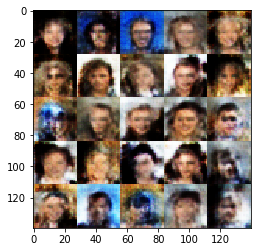

Epoch 1/2... Discriminator Loss: 1.4428... Generator Loss: 0.5194
Epoch 1/2... Discriminator Loss: 1.6077... Generator Loss: 0.3924
Epoch 1/2... Discriminator Loss: 1.2908... Generator Loss: 0.9838
Epoch 1/2... Discriminator Loss: 1.3580... Generator Loss: 0.8200
Epoch 1/2... Discriminator Loss: 1.4102... Generator Loss: 0.5408
Epoch 1/2... Discriminator Loss: 1.4779... Generator Loss: 1.1611
Epoch 1/2... Discriminator Loss: 1.2862... Generator Loss: 0.7501
Epoch 1/2... Discriminator Loss: 1.4576... Generator Loss: 0.5024
Epoch 1/2... Discriminator Loss: 1.4417... Generator Loss: 1.1756
Epoch 1/2... Discriminator Loss: 1.2776... Generator Loss: 0.8754


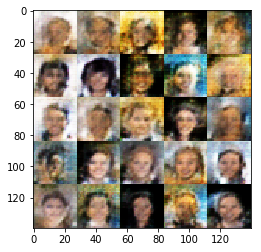

Epoch 1/2... Discriminator Loss: 1.2527... Generator Loss: 0.9527
Epoch 1/2... Discriminator Loss: 1.3805... Generator Loss: 0.7416
Epoch 1/2... Discriminator Loss: 1.2990... Generator Loss: 0.8077
Epoch 1/2... Discriminator Loss: 1.2741... Generator Loss: 0.9284
Epoch 1/2... Discriminator Loss: 1.1989... Generator Loss: 0.8657
Epoch 1/2... Discriminator Loss: 1.2757... Generator Loss: 0.9382
Epoch 1/2... Discriminator Loss: 1.5085... Generator Loss: 0.5762
Epoch 1/2... Discriminator Loss: 1.3932... Generator Loss: 0.5385
Epoch 1/2... Discriminator Loss: 1.2692... Generator Loss: 0.7891
Epoch 1/2... Discriminator Loss: 1.3286... Generator Loss: 0.9136


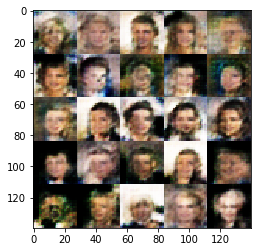

Epoch 1/2... Discriminator Loss: 1.2107... Generator Loss: 0.8750
Epoch 1/2... Discriminator Loss: 1.1910... Generator Loss: 0.9434
Epoch 1/2... Discriminator Loss: 1.3927... Generator Loss: 0.5497
Epoch 1/2... Discriminator Loss: 1.3040... Generator Loss: 0.9983
Epoch 1/2... Discriminator Loss: 1.4390... Generator Loss: 1.1869
Epoch 1/2... Discriminator Loss: 1.2828... Generator Loss: 0.6691
Epoch 1/2... Discriminator Loss: 1.3809... Generator Loss: 0.6394
Epoch 1/2... Discriminator Loss: 1.2633... Generator Loss: 1.7286
Epoch 1/2... Discriminator Loss: 1.2220... Generator Loss: 0.7093
Epoch 1/2... Discriminator Loss: 1.2736... Generator Loss: 0.9706


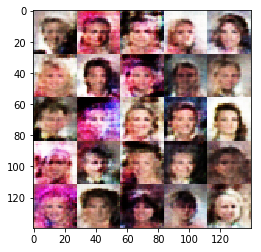

Epoch 1/2... Discriminator Loss: 1.4469... Generator Loss: 0.6234
Epoch 1/2... Discriminator Loss: 1.4226... Generator Loss: 1.5478
Epoch 1/2... Discriminator Loss: 1.4050... Generator Loss: 0.8507
Epoch 1/2... Discriminator Loss: 1.1332... Generator Loss: 1.4508
Epoch 1/2... Discriminator Loss: 1.3926... Generator Loss: 0.6890
Epoch 1/2... Discriminator Loss: 1.2714... Generator Loss: 0.8586
Epoch 1/2... Discriminator Loss: 1.1474... Generator Loss: 1.0908
Epoch 1/2... Discriminator Loss: 1.1971... Generator Loss: 1.0030
Epoch 1/2... Discriminator Loss: 1.0276... Generator Loss: 1.7667
Epoch 1/2... Discriminator Loss: 1.1972... Generator Loss: 0.8028


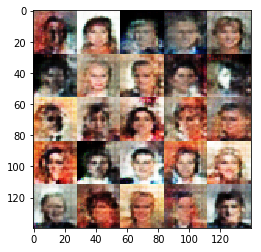

Epoch 1/2... Discriminator Loss: 1.2075... Generator Loss: 1.1308
Epoch 1/2... Discriminator Loss: 1.4266... Generator Loss: 0.5206
Epoch 1/2... Discriminator Loss: 1.2336... Generator Loss: 0.8181
Epoch 1/2... Discriminator Loss: 1.3899... Generator Loss: 0.5655
Epoch 1/2... Discriminator Loss: 1.6244... Generator Loss: 0.5216
Epoch 1/2... Discriminator Loss: 2.0744... Generator Loss: 2.4940
Epoch 1/2... Discriminator Loss: 1.5911... Generator Loss: 0.5059
Epoch 1/2... Discriminator Loss: 1.3378... Generator Loss: 0.9111
Epoch 1/2... Discriminator Loss: 1.1180... Generator Loss: 1.0582
Epoch 1/2... Discriminator Loss: 1.4011... Generator Loss: 0.5229


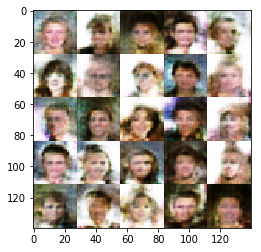

Epoch 1/2... Discriminator Loss: 1.0395... Generator Loss: 1.1130
Epoch 1/2... Discriminator Loss: 1.2719... Generator Loss: 1.1201
Epoch 1/2... Discriminator Loss: 1.0334... Generator Loss: 1.1276
Epoch 1/2... Discriminator Loss: 1.3121... Generator Loss: 0.8661
Epoch 1/2... Discriminator Loss: 1.0617... Generator Loss: 0.9886
Epoch 1/2... Discriminator Loss: 1.4291... Generator Loss: 1.5352
Epoch 1/2... Discriminator Loss: 1.3447... Generator Loss: 0.9772
Epoch 1/2... Discriminator Loss: 0.7531... Generator Loss: 1.3413
Epoch 1/2... Discriminator Loss: 1.1703... Generator Loss: 1.1956
Epoch 1/2... Discriminator Loss: 1.3553... Generator Loss: 0.5579


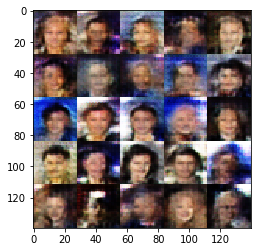

Epoch 1/2... Discriminator Loss: 1.0693... Generator Loss: 1.3363
Epoch 1/2... Discriminator Loss: 1.3427... Generator Loss: 0.8038
Epoch 1/2... Discriminator Loss: 1.1417... Generator Loss: 1.0395
Epoch 1/2... Discriminator Loss: 1.2839... Generator Loss: 0.8290
Epoch 1/2... Discriminator Loss: 1.2998... Generator Loss: 0.6848
Epoch 1/2... Discriminator Loss: 1.3273... Generator Loss: 0.6996
Epoch 1/2... Discriminator Loss: 1.4743... Generator Loss: 0.5163
Epoch 1/2... Discriminator Loss: 1.6078... Generator Loss: 0.5598
Epoch 1/2... Discriminator Loss: 1.3389... Generator Loss: 0.6330
Epoch 1/2... Discriminator Loss: 1.4509... Generator Loss: 0.5589


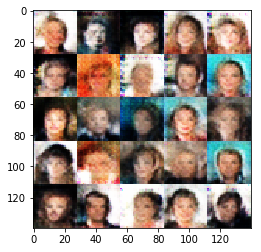

Epoch 1/2... Discriminator Loss: 1.4649... Generator Loss: 0.6380
Epoch 1/2... Discriminator Loss: 1.3055... Generator Loss: 0.7471
Epoch 1/2... Discriminator Loss: 1.2287... Generator Loss: 0.7996
Epoch 1/2... Discriminator Loss: 1.3926... Generator Loss: 0.5889
Epoch 1/2... Discriminator Loss: 1.4504... Generator Loss: 0.8592
Epoch 1/2... Discriminator Loss: 1.1557... Generator Loss: 0.9076
Epoch 1/2... Discriminator Loss: 1.2597... Generator Loss: 1.2490
Epoch 1/2... Discriminator Loss: 1.2615... Generator Loss: 0.9085
Epoch 1/2... Discriminator Loss: 1.4585... Generator Loss: 1.1636
Epoch 1/2... Discriminator Loss: 1.4391... Generator Loss: 1.0214


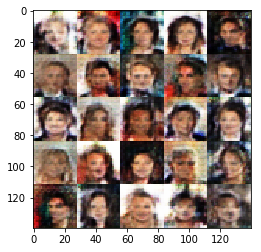

Epoch 1/2... Discriminator Loss: 1.2801... Generator Loss: 0.8231
Epoch 1/2... Discriminator Loss: 1.2769... Generator Loss: 0.7340
Epoch 1/2... Discriminator Loss: 1.2753... Generator Loss: 0.8828
Epoch 1/2... Discriminator Loss: 1.5464... Generator Loss: 0.5183
Epoch 1/2... Discriminator Loss: 1.2266... Generator Loss: 0.7982
Epoch 1/2... Discriminator Loss: 1.4772... Generator Loss: 0.8807
Epoch 1/2... Discriminator Loss: 1.2723... Generator Loss: 0.8580
Epoch 1/2... Discriminator Loss: 1.3718... Generator Loss: 0.8186
Epoch 1/2... Discriminator Loss: 1.2985... Generator Loss: 0.7872
Epoch 1/2... Discriminator Loss: 1.3199... Generator Loss: 0.7666


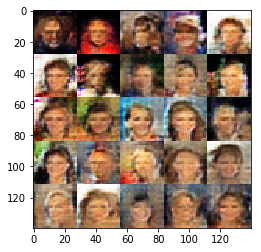

Epoch 1/2... Discriminator Loss: 1.3011... Generator Loss: 0.7608
Epoch 1/2... Discriminator Loss: 1.3897... Generator Loss: 1.0855
Epoch 1/2... Discriminator Loss: 1.7405... Generator Loss: 0.3366
Epoch 1/2... Discriminator Loss: 1.3830... Generator Loss: 0.6916
Epoch 1/2... Discriminator Loss: 1.2950... Generator Loss: 0.7002
Epoch 1/2... Discriminator Loss: 1.3204... Generator Loss: 0.7394
Epoch 1/2... Discriminator Loss: 1.2720... Generator Loss: 0.8437
Epoch 1/2... Discriminator Loss: 1.3614... Generator Loss: 0.7344
Epoch 1/2... Discriminator Loss: 1.3092... Generator Loss: 0.8440
Epoch 1/2... Discriminator Loss: 1.1857... Generator Loss: 1.2126


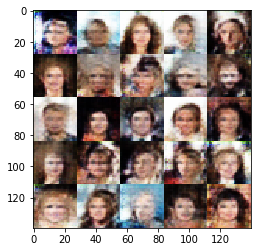

Epoch 1/2... Discriminator Loss: 1.3076... Generator Loss: 0.7542
Epoch 1/2... Discriminator Loss: 1.3196... Generator Loss: 0.7967
Epoch 1/2... Discriminator Loss: 1.5898... Generator Loss: 1.3227
Epoch 1/2... Discriminator Loss: 1.4934... Generator Loss: 0.5362
Epoch 1/2... Discriminator Loss: 1.3630... Generator Loss: 0.6904
Epoch 1/2... Discriminator Loss: 1.2058... Generator Loss: 0.8367
Epoch 1/2... Discriminator Loss: 1.2936... Generator Loss: 0.7071
Epoch 1/2... Discriminator Loss: 1.3205... Generator Loss: 0.8369
Epoch 1/2... Discriminator Loss: 1.2190... Generator Loss: 0.9870
Epoch 1/2... Discriminator Loss: 1.2177... Generator Loss: 0.9000


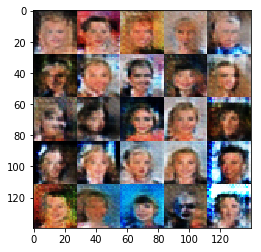

Epoch 1/2... Discriminator Loss: 1.3712... Generator Loss: 0.7572
Epoch 1/2... Discriminator Loss: 1.4129... Generator Loss: 0.6127
Epoch 1/2... Discriminator Loss: 1.3045... Generator Loss: 0.8737
Epoch 1/2... Discriminator Loss: 1.3286... Generator Loss: 0.8057
Epoch 1/2... Discriminator Loss: 1.3496... Generator Loss: 0.6810
Epoch 1/2... Discriminator Loss: 1.3690... Generator Loss: 0.7188
Epoch 1/2... Discriminator Loss: 1.2120... Generator Loss: 0.8803
Epoch 1/2... Discriminator Loss: 1.3035... Generator Loss: 0.9383
Epoch 1/2... Discriminator Loss: 1.3565... Generator Loss: 0.6787
Epoch 1/2... Discriminator Loss: 1.3873... Generator Loss: 0.8144


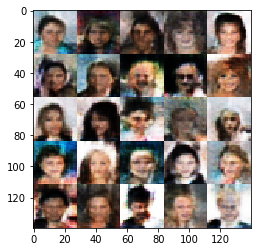

Epoch 1/2... Discriminator Loss: 1.1968... Generator Loss: 0.7484
Epoch 1/2... Discriminator Loss: 1.3483... Generator Loss: 0.6720
Epoch 1/2... Discriminator Loss: 1.3453... Generator Loss: 0.8095
Epoch 1/2... Discriminator Loss: 1.1331... Generator Loss: 0.9212
Epoch 1/2... Discriminator Loss: 1.4071... Generator Loss: 0.6220
Epoch 1/2... Discriminator Loss: 1.3753... Generator Loss: 0.6370
Epoch 1/2... Discriminator Loss: 1.3019... Generator Loss: 0.7343
Epoch 1/2... Discriminator Loss: 1.3158... Generator Loss: 0.6346
Epoch 1/2... Discriminator Loss: 1.3327... Generator Loss: 0.7097
Epoch 1/2... Discriminator Loss: 1.2776... Generator Loss: 0.9933


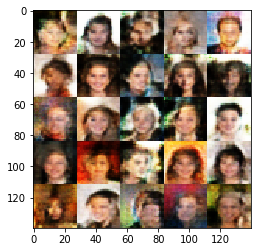

Epoch 1/2... Discriminator Loss: 1.4344... Generator Loss: 0.8894
Epoch 1/2... Discriminator Loss: 1.2291... Generator Loss: 0.9540
Epoch 1/2... Discriminator Loss: 1.1208... Generator Loss: 0.8752
Epoch 1/2... Discriminator Loss: 1.3683... Generator Loss: 0.5124
Epoch 1/2... Discriminator Loss: 1.4589... Generator Loss: 0.5848
Epoch 1/2... Discriminator Loss: 1.3414... Generator Loss: 0.8578
Epoch 1/2... Discriminator Loss: 1.2576... Generator Loss: 0.7575
Epoch 1/2... Discriminator Loss: 1.7025... Generator Loss: 0.3789
Epoch 1/2... Discriminator Loss: 1.4559... Generator Loss: 0.8785
Epoch 1/2... Discriminator Loss: 1.4598... Generator Loss: 1.3169


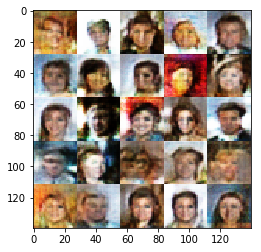

Epoch 1/2... Discriminator Loss: 1.3104... Generator Loss: 0.6366
Epoch 1/2... Discriminator Loss: 1.4104... Generator Loss: 0.7397
Epoch 1/2... Discriminator Loss: 1.3533... Generator Loss: 0.7855
Epoch 1/2... Discriminator Loss: 1.1978... Generator Loss: 1.0068
Epoch 1/2... Discriminator Loss: 1.3332... Generator Loss: 0.7416
Epoch 1/2... Discriminator Loss: 1.4462... Generator Loss: 1.1861
Epoch 1/2... Discriminator Loss: 1.3417... Generator Loss: 0.7221
Epoch 1/2... Discriminator Loss: 1.4727... Generator Loss: 0.5910
Epoch 1/2... Discriminator Loss: 1.3472... Generator Loss: 0.7136
Epoch 1/2... Discriminator Loss: 1.4322... Generator Loss: 1.0730


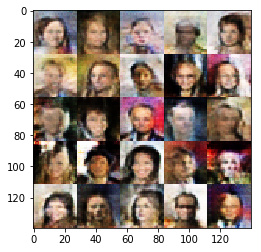

Epoch 1/2... Discriminator Loss: 1.4499... Generator Loss: 0.6509
Epoch 1/2... Discriminator Loss: 1.2319... Generator Loss: 0.8388
Epoch 1/2... Discriminator Loss: 1.3312... Generator Loss: 0.7758
Epoch 1/2... Discriminator Loss: 1.1179... Generator Loss: 1.0467
Epoch 1/2... Discriminator Loss: 1.2461... Generator Loss: 0.7423
Epoch 1/2... Discriminator Loss: 1.2775... Generator Loss: 0.6653
Epoch 2/2... Discriminator Loss: 1.3844... Generator Loss: 0.5861
Epoch 2/2... Discriminator Loss: 1.4494... Generator Loss: 0.5502
Epoch 2/2... Discriminator Loss: 1.3255... Generator Loss: 0.7881
Epoch 2/2... Discriminator Loss: 1.3595... Generator Loss: 0.9030


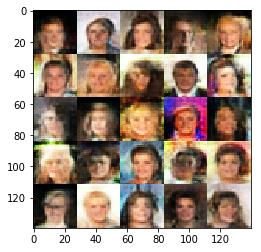

Epoch 2/2... Discriminator Loss: 1.3251... Generator Loss: 0.7301
Epoch 2/2... Discriminator Loss: 1.2668... Generator Loss: 0.7320
Epoch 2/2... Discriminator Loss: 1.3624... Generator Loss: 0.6973
Epoch 2/2... Discriminator Loss: 1.3160... Generator Loss: 0.8669
Epoch 2/2... Discriminator Loss: 1.3950... Generator Loss: 0.6086
Epoch 2/2... Discriminator Loss: 1.3584... Generator Loss: 0.7321
Epoch 2/2... Discriminator Loss: 1.3869... Generator Loss: 1.4430
Epoch 2/2... Discriminator Loss: 1.3502... Generator Loss: 0.8011
Epoch 2/2... Discriminator Loss: 1.3209... Generator Loss: 0.8711
Epoch 2/2... Discriminator Loss: 1.4327... Generator Loss: 0.7835


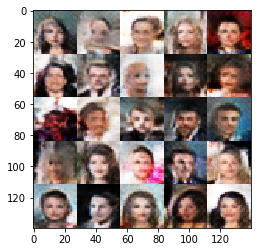

Epoch 2/2... Discriminator Loss: 1.3489... Generator Loss: 0.7232
Epoch 2/2... Discriminator Loss: 1.6642... Generator Loss: 1.0373
Epoch 2/2... Discriminator Loss: 1.2319... Generator Loss: 0.9094
Epoch 2/2... Discriminator Loss: 1.1909... Generator Loss: 0.9797
Epoch 2/2... Discriminator Loss: 1.2571... Generator Loss: 0.8090
Epoch 2/2... Discriminator Loss: 1.3528... Generator Loss: 0.8648
Epoch 2/2... Discriminator Loss: 1.5076... Generator Loss: 0.7073
Epoch 2/2... Discriminator Loss: 1.3670... Generator Loss: 0.5914
Epoch 2/2... Discriminator Loss: 1.3007... Generator Loss: 0.8479
Epoch 2/2... Discriminator Loss: 1.2619... Generator Loss: 0.8708


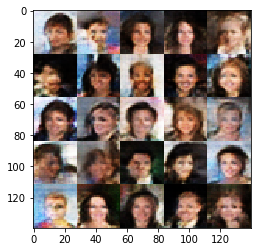

Epoch 2/2... Discriminator Loss: 1.3400... Generator Loss: 0.6437
Epoch 2/2... Discriminator Loss: 1.2718... Generator Loss: 0.8665
Epoch 2/2... Discriminator Loss: 1.3404... Generator Loss: 0.7951
Epoch 2/2... Discriminator Loss: 1.4152... Generator Loss: 0.7067
Epoch 2/2... Discriminator Loss: 1.3156... Generator Loss: 0.8704
Epoch 2/2... Discriminator Loss: 1.4397... Generator Loss: 0.7936
Epoch 2/2... Discriminator Loss: 1.5582... Generator Loss: 0.4715
Epoch 2/2... Discriminator Loss: 1.2510... Generator Loss: 0.8217
Epoch 2/2... Discriminator Loss: 1.4691... Generator Loss: 0.5764
Epoch 2/2... Discriminator Loss: 1.2953... Generator Loss: 0.8791


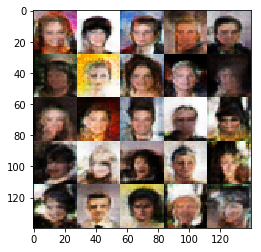

Epoch 2/2... Discriminator Loss: 1.4078... Generator Loss: 0.6452
Epoch 2/2... Discriminator Loss: 1.3624... Generator Loss: 0.9583
Epoch 2/2... Discriminator Loss: 1.2113... Generator Loss: 0.8657
Epoch 2/2... Discriminator Loss: 1.4173... Generator Loss: 0.6251
Epoch 2/2... Discriminator Loss: 1.2604... Generator Loss: 0.9329
Epoch 2/2... Discriminator Loss: 1.3051... Generator Loss: 0.7301
Epoch 2/2... Discriminator Loss: 1.1442... Generator Loss: 0.9713
Epoch 2/2... Discriminator Loss: 1.3564... Generator Loss: 0.8697
Epoch 2/2... Discriminator Loss: 1.4273... Generator Loss: 0.6794
Epoch 2/2... Discriminator Loss: 1.3260... Generator Loss: 0.8041


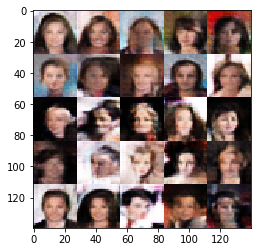

Epoch 2/2... Discriminator Loss: 1.4975... Generator Loss: 0.5058
Epoch 2/2... Discriminator Loss: 1.4015... Generator Loss: 0.8866
Epoch 2/2... Discriminator Loss: 1.2977... Generator Loss: 0.7640
Epoch 2/2... Discriminator Loss: 1.3915... Generator Loss: 0.5897
Epoch 2/2... Discriminator Loss: 1.3632... Generator Loss: 0.5824
Epoch 2/2... Discriminator Loss: 1.2968... Generator Loss: 0.7026
Epoch 2/2... Discriminator Loss: 1.3742... Generator Loss: 0.7683
Epoch 2/2... Discriminator Loss: 1.2482... Generator Loss: 0.8645
Epoch 2/2... Discriminator Loss: 1.3524... Generator Loss: 0.9105
Epoch 2/2... Discriminator Loss: 1.3112... Generator Loss: 0.7191


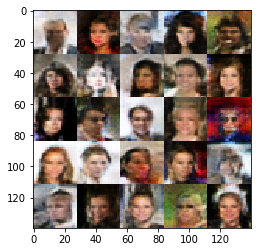

Epoch 2/2... Discriminator Loss: 1.3308... Generator Loss: 0.7554
Epoch 2/2... Discriminator Loss: 1.4815... Generator Loss: 0.4899
Epoch 2/2... Discriminator Loss: 1.2973... Generator Loss: 0.8572
Epoch 2/2... Discriminator Loss: 1.1947... Generator Loss: 0.9613
Epoch 2/2... Discriminator Loss: 1.2967... Generator Loss: 0.8152
Epoch 2/2... Discriminator Loss: 1.4187... Generator Loss: 0.7584
Epoch 2/2... Discriminator Loss: 1.2956... Generator Loss: 0.8876
Epoch 2/2... Discriminator Loss: 1.4172... Generator Loss: 0.7085
Epoch 2/2... Discriminator Loss: 1.2630... Generator Loss: 0.9940
Epoch 2/2... Discriminator Loss: 1.3118... Generator Loss: 0.6150


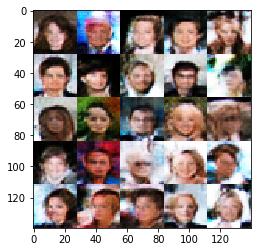

Epoch 2/2... Discriminator Loss: 1.6394... Generator Loss: 1.1350
Epoch 2/2... Discriminator Loss: 1.3624... Generator Loss: 0.8041
Epoch 2/2... Discriminator Loss: 1.3439... Generator Loss: 0.9065
Epoch 2/2... Discriminator Loss: 1.3861... Generator Loss: 0.8061
Epoch 2/2... Discriminator Loss: 1.3240... Generator Loss: 0.6856
Epoch 2/2... Discriminator Loss: 1.2750... Generator Loss: 0.8447
Epoch 2/2... Discriminator Loss: 1.2981... Generator Loss: 0.7968
Epoch 2/2... Discriminator Loss: 1.4314... Generator Loss: 0.7425
Epoch 2/2... Discriminator Loss: 1.2733... Generator Loss: 0.8028
Epoch 2/2... Discriminator Loss: 1.4019... Generator Loss: 0.5874


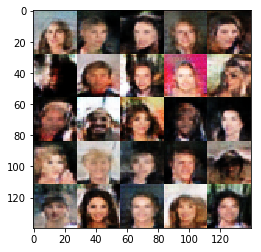

Epoch 2/2... Discriminator Loss: 1.3271... Generator Loss: 0.8313
Epoch 2/2... Discriminator Loss: 1.3512... Generator Loss: 0.7972
Epoch 2/2... Discriminator Loss: 1.3256... Generator Loss: 0.8150
Epoch 2/2... Discriminator Loss: 1.5235... Generator Loss: 0.4908
Epoch 2/2... Discriminator Loss: 1.2062... Generator Loss: 0.9309
Epoch 2/2... Discriminator Loss: 1.3163... Generator Loss: 1.0326
Epoch 2/2... Discriminator Loss: 1.4003... Generator Loss: 0.5970
Epoch 2/2... Discriminator Loss: 1.3392... Generator Loss: 0.6795
Epoch 2/2... Discriminator Loss: 1.3294... Generator Loss: 0.7169
Epoch 2/2... Discriminator Loss: 1.3947... Generator Loss: 0.7534


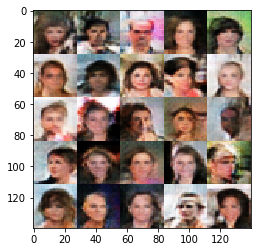

Epoch 2/2... Discriminator Loss: 1.3697... Generator Loss: 0.6808
Epoch 2/2... Discriminator Loss: 1.2083... Generator Loss: 0.9024
Epoch 2/2... Discriminator Loss: 1.4709... Generator Loss: 0.5072
Epoch 2/2... Discriminator Loss: 1.4394... Generator Loss: 0.5992
Epoch 2/2... Discriminator Loss: 1.5387... Generator Loss: 0.5268
Epoch 2/2... Discriminator Loss: 1.3897... Generator Loss: 0.6714
Epoch 2/2... Discriminator Loss: 1.3412... Generator Loss: 0.6727
Epoch 2/2... Discriminator Loss: 1.2708... Generator Loss: 0.6912
Epoch 2/2... Discriminator Loss: 1.4757... Generator Loss: 1.3873
Epoch 2/2... Discriminator Loss: 1.4237... Generator Loss: 0.8716


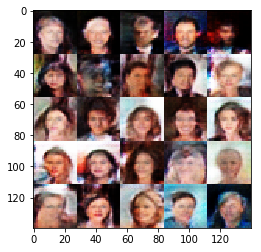

Epoch 2/2... Discriminator Loss: 1.4581... Generator Loss: 1.0765
Epoch 2/2... Discriminator Loss: 1.3523... Generator Loss: 0.7717
Epoch 2/2... Discriminator Loss: 1.3384... Generator Loss: 0.6759
Epoch 2/2... Discriminator Loss: 1.2798... Generator Loss: 0.9436
Epoch 2/2... Discriminator Loss: 1.2245... Generator Loss: 1.0537
Epoch 2/2... Discriminator Loss: 1.3281... Generator Loss: 0.7361
Epoch 2/2... Discriminator Loss: 1.4917... Generator Loss: 1.1539
Epoch 2/2... Discriminator Loss: 1.4104... Generator Loss: 0.7425
Epoch 2/2... Discriminator Loss: 1.3627... Generator Loss: 0.6843
Epoch 2/2... Discriminator Loss: 1.3355... Generator Loss: 0.7039


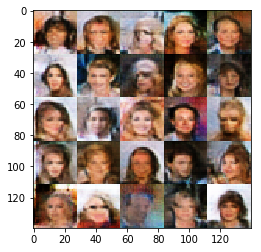

Epoch 2/2... Discriminator Loss: 1.4201... Generator Loss: 0.5916
Epoch 2/2... Discriminator Loss: 1.2659... Generator Loss: 0.8462
Epoch 2/2... Discriminator Loss: 1.3642... Generator Loss: 0.6982
Epoch 2/2... Discriminator Loss: 1.3574... Generator Loss: 0.7086
Epoch 2/2... Discriminator Loss: 1.3133... Generator Loss: 0.8529
Epoch 2/2... Discriminator Loss: 1.5661... Generator Loss: 1.7221
Epoch 2/2... Discriminator Loss: 1.2901... Generator Loss: 0.6949
Epoch 2/2... Discriminator Loss: 1.2585... Generator Loss: 0.8558
Epoch 2/2... Discriminator Loss: 1.2523... Generator Loss: 0.9196
Epoch 2/2... Discriminator Loss: 1.2917... Generator Loss: 0.8013


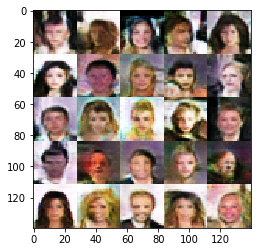

Epoch 2/2... Discriminator Loss: 1.2386... Generator Loss: 0.7958
Epoch 2/2... Discriminator Loss: 1.3857... Generator Loss: 0.7218
Epoch 2/2... Discriminator Loss: 1.3970... Generator Loss: 0.6608
Epoch 2/2... Discriminator Loss: 1.2536... Generator Loss: 0.8417
Epoch 2/2... Discriminator Loss: 1.3535... Generator Loss: 0.8409
Epoch 2/2... Discriminator Loss: 1.2852... Generator Loss: 0.6648
Epoch 2/2... Discriminator Loss: 1.2179... Generator Loss: 1.0739
Epoch 2/2... Discriminator Loss: 1.3677... Generator Loss: 0.6078
Epoch 2/2... Discriminator Loss: 1.5013... Generator Loss: 0.6071
Epoch 2/2... Discriminator Loss: 1.3961... Generator Loss: 0.7489


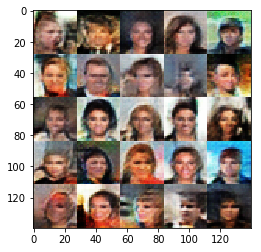

Epoch 2/2... Discriminator Loss: 1.3290... Generator Loss: 0.7737
Epoch 2/2... Discriminator Loss: 1.4247... Generator Loss: 0.7225
Epoch 2/2... Discriminator Loss: 1.3548... Generator Loss: 0.6830
Epoch 2/2... Discriminator Loss: 1.3594... Generator Loss: 0.6846
Epoch 2/2... Discriminator Loss: 1.2957... Generator Loss: 0.9513
Epoch 2/2... Discriminator Loss: 1.3130... Generator Loss: 0.7371
Epoch 2/2... Discriminator Loss: 1.2161... Generator Loss: 0.8920
Epoch 2/2... Discriminator Loss: 1.3073... Generator Loss: 0.9353
Epoch 2/2... Discriminator Loss: 1.2551... Generator Loss: 0.7829
Epoch 2/2... Discriminator Loss: 1.3899... Generator Loss: 0.6893


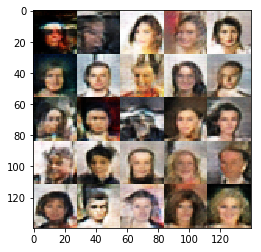

Epoch 2/2... Discriminator Loss: 1.2526... Generator Loss: 0.9156
Epoch 2/2... Discriminator Loss: 1.5688... Generator Loss: 0.4189
Epoch 2/2... Discriminator Loss: 1.3185... Generator Loss: 0.9008
Epoch 2/2... Discriminator Loss: 1.3583... Generator Loss: 0.5359
Epoch 2/2... Discriminator Loss: 1.3123... Generator Loss: 0.8953
Epoch 2/2... Discriminator Loss: 1.3906... Generator Loss: 0.8905
Epoch 2/2... Discriminator Loss: 1.4374... Generator Loss: 0.7146
Epoch 2/2... Discriminator Loss: 1.3044... Generator Loss: 0.8258
Epoch 2/2... Discriminator Loss: 1.3670... Generator Loss: 0.8625
Epoch 2/2... Discriminator Loss: 1.2569... Generator Loss: 0.7923


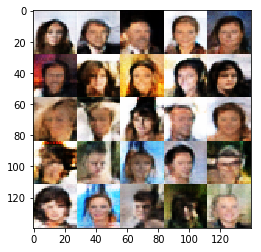

Epoch 2/2... Discriminator Loss: 1.3055... Generator Loss: 0.9272
Epoch 2/2... Discriminator Loss: 1.3273... Generator Loss: 0.8150
Epoch 2/2... Discriminator Loss: 1.3281... Generator Loss: 0.7327
Epoch 2/2... Discriminator Loss: 1.4025... Generator Loss: 0.5934
Epoch 2/2... Discriminator Loss: 1.2172... Generator Loss: 0.7906
Epoch 2/2... Discriminator Loss: 1.4034... Generator Loss: 0.7237
Epoch 2/2... Discriminator Loss: 1.3828... Generator Loss: 0.7557
Epoch 2/2... Discriminator Loss: 1.4036... Generator Loss: 0.7257
Epoch 2/2... Discriminator Loss: 1.3147... Generator Loss: 0.6810
Epoch 2/2... Discriminator Loss: 1.3225... Generator Loss: 0.8850


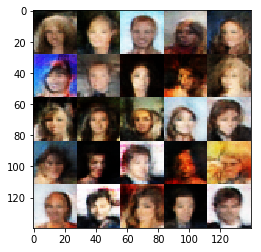

Epoch 2/2... Discriminator Loss: 1.2704... Generator Loss: 0.6300
Epoch 2/2... Discriminator Loss: 1.5956... Generator Loss: 0.5101
Epoch 2/2... Discriminator Loss: 1.3243... Generator Loss: 0.8433
Epoch 2/2... Discriminator Loss: 1.4933... Generator Loss: 0.4794
Epoch 2/2... Discriminator Loss: 1.3988... Generator Loss: 0.6473
Epoch 2/2... Discriminator Loss: 1.0296... Generator Loss: 1.1486
Epoch 2/2... Discriminator Loss: 1.5706... Generator Loss: 0.4254
Epoch 2/2... Discriminator Loss: 1.4178... Generator Loss: 1.2247
Epoch 2/2... Discriminator Loss: 1.5290... Generator Loss: 0.5599
Epoch 2/2... Discriminator Loss: 1.2142... Generator Loss: 0.7512


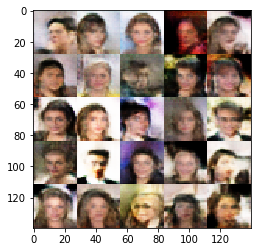

Epoch 2/2... Discriminator Loss: 1.4339... Generator Loss: 0.8321
Epoch 2/2... Discriminator Loss: 1.3387... Generator Loss: 0.8494
Epoch 2/2... Discriminator Loss: 1.4349... Generator Loss: 0.6622
Epoch 2/2... Discriminator Loss: 1.3208... Generator Loss: 0.8056
Epoch 2/2... Discriminator Loss: 1.3526... Generator Loss: 0.8275
Epoch 2/2... Discriminator Loss: 1.2893... Generator Loss: 0.5723
Epoch 2/2... Discriminator Loss: 1.3422... Generator Loss: 0.8928
Epoch 2/2... Discriminator Loss: 1.3242... Generator Loss: 0.6226
Epoch 2/2... Discriminator Loss: 1.3800... Generator Loss: 0.8619
Epoch 2/2... Discriminator Loss: 1.2802... Generator Loss: 0.8841


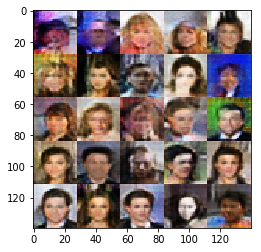

Epoch 2/2... Discriminator Loss: 1.2009... Generator Loss: 0.8715
Epoch 2/2... Discriminator Loss: 1.3552... Generator Loss: 0.7126
Epoch 2/2... Discriminator Loss: 1.4121... Generator Loss: 0.6659
Epoch 2/2... Discriminator Loss: 1.3383... Generator Loss: 0.7535
Epoch 2/2... Discriminator Loss: 1.6288... Generator Loss: 0.3981
Epoch 2/2... Discriminator Loss: 1.1693... Generator Loss: 0.9545
Epoch 2/2... Discriminator Loss: 1.7057... Generator Loss: 1.7833
Epoch 2/2... Discriminator Loss: 1.2842... Generator Loss: 0.8545
Epoch 2/2... Discriminator Loss: 1.3467... Generator Loss: 0.9676
Epoch 2/2... Discriminator Loss: 1.4553... Generator Loss: 0.5442


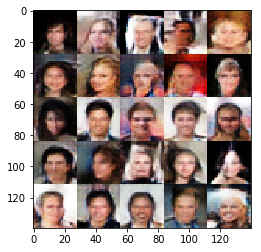

Epoch 2/2... Discriminator Loss: 1.3091... Generator Loss: 0.7101
Epoch 2/2... Discriminator Loss: 1.2585... Generator Loss: 0.9878
Epoch 2/2... Discriminator Loss: 1.0758... Generator Loss: 1.2846
Epoch 2/2... Discriminator Loss: 1.2472... Generator Loss: 0.8049
Epoch 2/2... Discriminator Loss: 1.3307... Generator Loss: 0.7412
Epoch 2/2... Discriminator Loss: 1.3732... Generator Loss: 0.8154
Epoch 2/2... Discriminator Loss: 1.3559... Generator Loss: 0.6913
Epoch 2/2... Discriminator Loss: 1.2959... Generator Loss: 0.7848
Epoch 2/2... Discriminator Loss: 1.2362... Generator Loss: 0.8060
Epoch 2/2... Discriminator Loss: 1.4634... Generator Loss: 0.9531


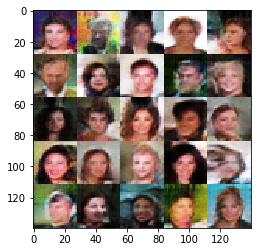

Epoch 2/2... Discriminator Loss: 1.3713... Generator Loss: 0.5657
Epoch 2/2... Discriminator Loss: 1.0711... Generator Loss: 1.1749
Epoch 2/2... Discriminator Loss: 1.3126... Generator Loss: 0.9642
Epoch 2/2... Discriminator Loss: 1.3903... Generator Loss: 0.7490
Epoch 2/2... Discriminator Loss: 1.2451... Generator Loss: 0.8898
Epoch 2/2... Discriminator Loss: 1.3332... Generator Loss: 0.6002
Epoch 2/2... Discriminator Loss: 1.6101... Generator Loss: 0.3800
Epoch 2/2... Discriminator Loss: 1.3766... Generator Loss: 0.9733
Epoch 2/2... Discriminator Loss: 1.2376... Generator Loss: 0.8713
Epoch 2/2... Discriminator Loss: 1.2941... Generator Loss: 0.7669


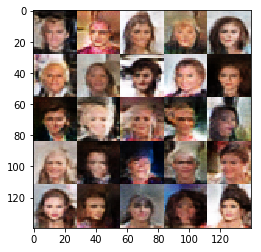

Epoch 2/2... Discriminator Loss: 1.3187... Generator Loss: 0.6821
Epoch 2/2... Discriminator Loss: 1.5106... Generator Loss: 0.4941


KeyboardInterrupt: 

In [30]:
with tf.Graph().as_default():
    
    input_real, input_z, lr = model_inputs(CELEBA_IMAGE_RESHAPED_WIDTH, CELEBA_IMAGE_RESHAPED_HEIGHT, 
                                           CELEBA_NUM_CHANNELS, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, CELEBA_NUM_CHANNELS)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1) 
    
    steps=0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epochs):
            
            mini_batches = prepare_mini_batches(celeba_images_preprocessed, batch_size)
            while mini_batches:
                steps += 1
                
                batch_d = mini_batches.pop()
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
           
                _ = sess.run(d_train_opt, 
                             feed_dict={input_real: batch_d, 
                                        input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, 
                             feed_dict={input_real: batch_d, 
                                        input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_d, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format((epoch_i + 1), epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    example_input = np.random.uniform(-1, 1, size=[25, z_dim])

                    generated_samples = sess.run(
                        generator(input_z, CELEBA_NUM_CHANNELS, 
                                  reuse=True, is_training=False), 
                        feed_dict={input_z: example_input})

                    generated_samples_grid = get_images_grid(
                        generated_samples, len(generated_samples), 5, "RGB")

                    pyplot.imshow(generated_samples_grid)
                    pyplot.show()